In [ ]:
!git clone https://github.com/iShohei220/adopt.git

# CLONE REPO GITHUB NÀY ĐỂ SỬ DỤNG ADOPT OPTIMIZER

fatal: destination path 'adopt' already exists and is not an empty directory.


In [ ]:
!conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia --yes

# DÒNG NÀY TÔI SỬ DỤNG ĐỂ CÀI CÁC THƯ VIỆN CẦN THIẾT TRÊN KAGGLE ĐIỂN HÌNH LÀ PYTORCH 2.5.1
# VÌ ADOPT BẮT BUỘC PYTORCH > 2.5

# NẾU SỬ DỤNG GOOGLE COLAB THÌ CÓ THỂ BỎ QUA DÒNG NÀY 

# IMPORT LIBRARY

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [58]:
import torch
print(torch.__version__)
print("CUDA version from PyTorch:", torch.version.cuda)

2.5.1+cu121
CUDA version from PyTorch: 12.1


In [ ]:
import sys
sys.path.append('/content/adopt')

from adopt import ADOPT

# DÒNG NÀY THÊM ĐƯỜNG DẪN /content/adopt VÀO DANH SÁCH ĐƯỜNG DẪN MÀ PYTHON SỬ DỤNG ĐỂ TÌM KIẾM CÁC MODULE
# Ở TRÊN ĐANG APPEND MỘT DIRECTORY adopt TRÊN GOOGLE COLAB, adopt NẰM TRONG GITHUB REPO MÀ TA CLONE VỀ
# NẾU DÙNG GOOGLE COLAB THÌ SẼ LÀ sys.path.append('/kaggle/working/adopt')

# CIFAR 10

In [60]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the data (scaling the pixel values to the range [0, 1])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the labels (CIFAR-10 labels are in shape (n, 1))
y_train = y_train.flatten()
y_test = y_test.flatten()

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print shapes of the datasets
print("X_train shape : ", x_train.shape)
print("Y_train shape : ", y_train.shape)
print("X_val shape : ", x_val.shape)
print("Y_val shape : ", y_val.shape)
print("X_test shape : ", x_test.shape)
print("Y_test shape : ", y_test.shape)

X_train shape :  (40000, 32, 32, 3)
Y_train shape :  (40000,)
X_val shape :  (10000, 32, 32, 3)
Y_val shape :  (10000,)
X_test shape :  (10000, 32, 32, 3)
Y_test shape :  (10000,)


In [61]:
num_classes = len(set(y_train))
print(f"Số loại nhãn trong y_train: {num_classes}")

Số loại nhãn trong y_train: 10


In [62]:
def transform_data(data, label, batch_size=32):
    """
    Chuyển dữ liệu từ NumPy array sang PyTorch tensor và tạo DataLoader cho CIFAR-10.

    Args:
        data (numpy.ndarray): Dữ liệu đầu vào (hình ảnh).
        label (numpy.ndarray): Nhãn tương ứng.
        batch_size (int): Kích thước batch khi huấn luyện.

    Returns:
        DataLoader: DataLoader để huấn luyện hoặc kiểm tra.
    """
    # Chuyển `data` từ NumPy array sang PyTorch tensor kiểu float32 và định dạng (N, C, H, W)
    data = torch.from_numpy(data).float().permute(0, 3, 1, 2)  # Chuyển (N, H, W, C) -> (N, C, H, W)

    # Chuyển `label` từ NumPy array sang tensor kiểu long
    label = torch.from_numpy(label).long().squeeze()  # Xóa trục dư thừa nếu nhãn ở dạng (N, 1)

    # Tạo TensorDataset và DataLoader
    _data = TensorDataset(data, label)
    data_loader = DataLoader(_data, batch_size=batch_size, shuffle=True)

    return data_loader

In [63]:
train_loader = transform_data(x_train, y_train)
test_loader = transform_data(x_test, y_test)
val_loader = transform_data(x_val, y_val)

In [64]:
# Hàm để in kích thước của data và label trong DataLoader
def print_loader_shapes(data_loader, loader_name):
    print(f"\n{loader_name}:")

    for batch_idx, (data, labels) in enumerate(data_loader):
        print(f"  Batch {batch_idx + 1}:")
        print(f"    Data shape: {data.shape}")   # Kích thước của dữ liệu
        print(f"    Labels shape: {labels.shape}")  # Kích thước của nhãn
        break  # Dừng sau batch đầu tiên (nếu chỉ cần kiểm tra một batch)

# In kích thước của từng DataLoader
print_loader_shapes(train_loader, "Train Loader")
print_loader_shapes(test_loader, "Test Loader")
print_loader_shapes(val_loader, "Validation Loader")


Train Loader:
  Batch 1:
    Data shape: torch.Size([32, 3, 32, 32])
    Labels shape: torch.Size([32])

Test Loader:
  Batch 1:
    Data shape: torch.Size([32, 3, 32, 32])
    Labels shape: torch.Size([32])

Validation Loader:
  Batch 1:
    Data shape: torch.Size([32, 3, 32, 32])
    Labels shape: torch.Size([32])


# MODEL

In [65]:
class ResNet18(nn.Module):
    def __init__(self, model, num_classes=10):
        super(ResNet18, self).__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def fit(self, num_epochs, optimizer_type, train_loader, val_loader, base_lr = 0.01, weight_decay=0.0001, scheduler=None, verbose=False):
        """
        Hàm huấn luyện mô hình.
        Args:
            num_epochs (int): Số epoch huấn luyện.
            optimizer (torch.optim.Optimizer): Optimizer được sử dụng.
            train_loader (DataLoader): Bộ dữ liệu huấn luyện.
            val_loader (DataLoader): Bộ dữ liệu kiểm tra (validation).
            scheduler (torch.optim.lr_scheduler._LRScheduler): Lịch điều chỉnh learning rate (nếu có).
            verbose (bool): In thông tin chi tiết khi huấn luyện.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        if(optimizer_type == "Adam"):
            optimizer = optim.Adam(self.parameters(), weight_decay=weight_decay)
        elif(optimizer_type == "ADOPT"):
            optimizer = ADOPT(self.parameters(),weight_decay=weight_decay)


        history = {
            'step_loss': [],
            'step_accuracy': [],
            'step_val_accuracy': [],
            'epoch_loss': [],
            'epoch_accuracy': [],
            'val_accuracy': []
        }

        iteration = 0
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                iteration += 1

                lr = base_lr / (iteration ** 0.5)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                step_loss = loss.item()
                step_accuracy = correct_train / total_train
                history['step_loss'].append(step_loss)
                history['step_accuracy'].append(step_accuracy)


                if verbose and ((i+1) % 100 == 0):
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                          f"Loss: {step_loss:.6f}, Train Accuracy: {step_accuracy:.6f}")

            # Tổng hợp kết quả epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct_train / total_train
            history['epoch_loss'].append(epoch_loss)
            history['epoch_accuracy'].append(epoch_accuracy)

            # Đánh giá trên toàn bộ validation set
            val_accuracy = self._evaluate(val_loader, device)
            history['val_accuracy'].append(val_accuracy)


            if scheduler:
                scheduler.step()

            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}, "
                      f"Train Accuracy: {epoch_accuracy:.6f}, Validation Accuracy: {val_accuracy:.6f}")
        return history


    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        self.eval()
        predictions = []

        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return np.array(predictions)


    def evaluate(self, test_loader):
        """
        Tính độ chính xác (accuracy) trên tập test.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        accuracy = self._evaluate(test_loader, device)
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

    def _evaluate(self, data_loader, device):
        """
        Hàm hỗ trợ tính độ chính xác cho cả validation và test.
        """
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total



# TRAIN

In [66]:
list_optimizer = [ "ADOPT","Adam"]
num_epochs = 100
result = {}
num_classes = 10
for optimizer_type in list_optimizer:
    resnet18 = models.resnet18(pretrained=True)
    in_features = resnet18.fc.in_features
    resnet18.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
    # print(resnet18)
    # resnet18.fc = nn.Linear(in_features, num_classes)
    model = ResNet18(resnet18, num_classes=10)
    history = model.fit(num_epochs=num_epochs, optimizer_type = optimizer_type, train_loader=train_loader, val_loader=val_loader, base_lr= 0.01, verbose=True)
    result[optimizer_type] = history

Epoch [1/100], Step [100/1250], Loss: 1.456789, Train Accuracy: 0.305000
Epoch [1/100], Step [200/1250], Loss: 1.202838, Train Accuracy: 0.372656
Epoch [1/100], Step [300/1250], Loss: 1.085090, Train Accuracy: 0.423021
Epoch [1/100], Step [400/1250], Loss: 1.271137, Train Accuracy: 0.456328
Epoch [1/100], Step [500/1250], Loss: 1.330687, Train Accuracy: 0.481875
Epoch [1/100], Step [600/1250], Loss: 1.127979, Train Accuracy: 0.501719
Epoch [1/100], Step [700/1250], Loss: 1.078756, Train Accuracy: 0.515804
Epoch [1/100], Step [800/1250], Loss: 0.761440, Train Accuracy: 0.531484
Epoch [1/100], Step [900/1250], Loss: 0.836502, Train Accuracy: 0.544444
Epoch [1/100], Step [1000/1250], Loss: 0.768878, Train Accuracy: 0.556375
Epoch [1/100], Step [1100/1250], Loss: 1.061478, Train Accuracy: 0.567102
Epoch [1/100], Step [1200/1250], Loss: 0.866157, Train Accuracy: 0.577656
Epoch 1/100, Loss: 1.211368, Train Accuracy: 0.582225, Validation Accuracy: 0.721800
Epoch [2/100], Step [100/1250], Loss

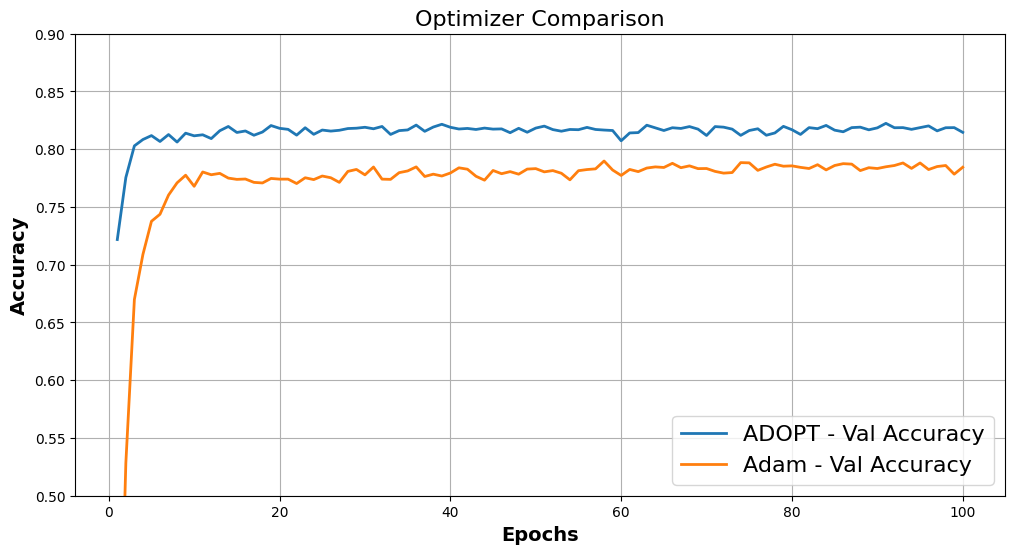

In [73]:
# Hàm vẽ biểu đồ so sánh
def plot_training_validation_accuracy(result, num_epochs):
    """
    Hàm vẽ biểu đồ so sánh độ chính xác huấn luyện và kiểm tra giữa các optimizer.

    Args:
        result (dict): Lịch sử huấn luyện của các optimizer, chứa các khóa là tên optimizer và giá trị là `history`.
        num_epochs (int): Số lượng epoch huấn luyện.
    """
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    for optimizer_type in list_optimizer:
        # Vẽ độ chính xác huấn luyện
        plt.plot(epochs, result[optimizer_type]['val_accuracy'], label=f'{optimizer_type} - Val Accuracy', linewidth=2)

    plt.ylim(0.5, 0.9)
    # Thiết lập biểu đồ
    plt.title('Optimizer Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14, fontweight = "bold")
    plt.ylabel('Accuracy', fontsize=14, fontweight = "bold")
    plt.legend(fontsize=16, loc='lower right', )
    plt.grid(True)
    plt.show()

# Vẽ biểu đồ từ kết quả
plot_training_validation_accuracy(result, num_epochs)
